# 1. Combining Data and Early Cleaning
The original data had three files: *plays.csv*, *games.csv*, *PFFScoutingData.csv*, along with the tracking data for the 2018, 2019, and 2020 seasons. I wanted to combine all of these into one data set, reduce it to the observations and variables that I needed for my analysis, and clean/change some variables.

## 1.1 Importing 2018 Data

In [11]:
library(tidyverse)
library(here)

source(here("R", "00_source.R"))

trackingData <- read.csv(here("data", "trackingData2018.csv"))
playData <- read.csv(here("data", "plays.csv"))
gameData <- read.csv(here("data", "games.csv"))
PFFData <- read.csv(here("data", "PFFScoutingData.csv"))

mergedData <- trackingData %>% 
  inner_join(PFFData) %>% 
  inner_join(playData) %>% 
  inner_join(gameData)

Joining, by = c("gameId", "playId")
Joining, by = c("gameId", "playId")
Joining, by = "gameId"


## 1.2 Clean 2018 Punt Plays
Looking at 5 rows shows the structure of some important variables. This dataset includes all special teams plays. Gunners and vises/jammers are listed with their team abbreviation and jersey number separated by a semi-colon. There could also be a different number of gunners and jammers on each play.

In [12]:
mergedData[c(66284, 1407808, 23, 56465), c("specialTeamsPlayType", "gunners", "vises", "returnerId")]

,specialTeamsPlayType,gunners,vises,returnerId
,<chr>,<chr>,<chr>,<chr>
66284,Punt,HOU 33; HOU 23,JAX 41; JAX 38; JAX 43,44923
1407808,Punt,DEN 38; DEN 81,CIN 20; CIN 21,43663
23,Punt,CLE 27; CLE 31,BAL 28; BAL 26,43349
56465,Punt,DET 18; DET 30,GB 21; GB 28,46114


### 1.2.1 Exploring How Many Gunners, Jammers, and Returners Are Usually Fielded
Since the players in each position (gunner, jammer, returner) are separated by a semi-colon, the number of players can be found by counting the number of semi-colons and adding one. Here we can see that most plays feature 2 gunners, 2 jammers, and 1 returner. For simplicity, I will only be looking at these plays in my analysis. 

Warning message:
"Removed 14078 rows containing non-finite values (stat_count)."


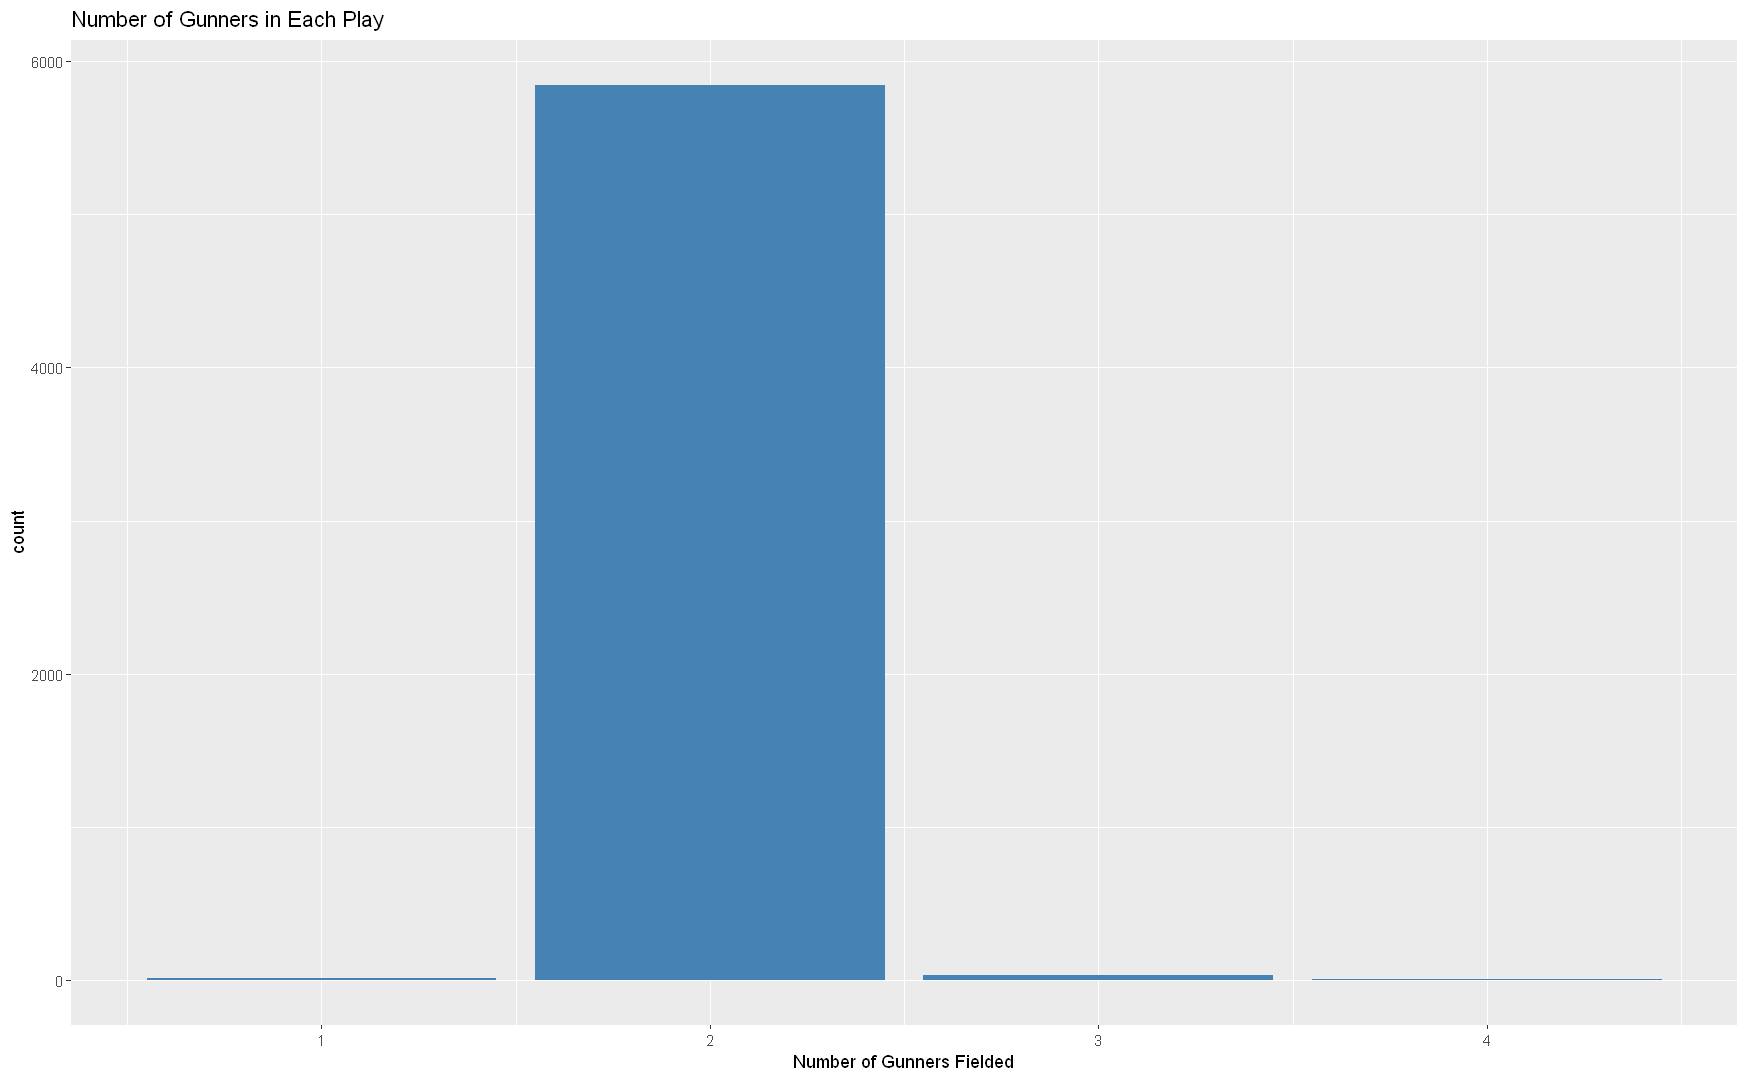

In [13]:
# adjust plot size
options(repr.plot.width=14.5623, repr.plot.height=9)

ggplot(data=PFFData, aes(x=str_count(gunners, ';') + 1)) +
  geom_bar(stat="count", fill = "steelblue") +
  ggtitle("Number of Gunners in Each Play") +
  xlab("Number of Gunners Fielded")

Warning message:
"Removed 14101 rows containing non-finite values (stat_count)."


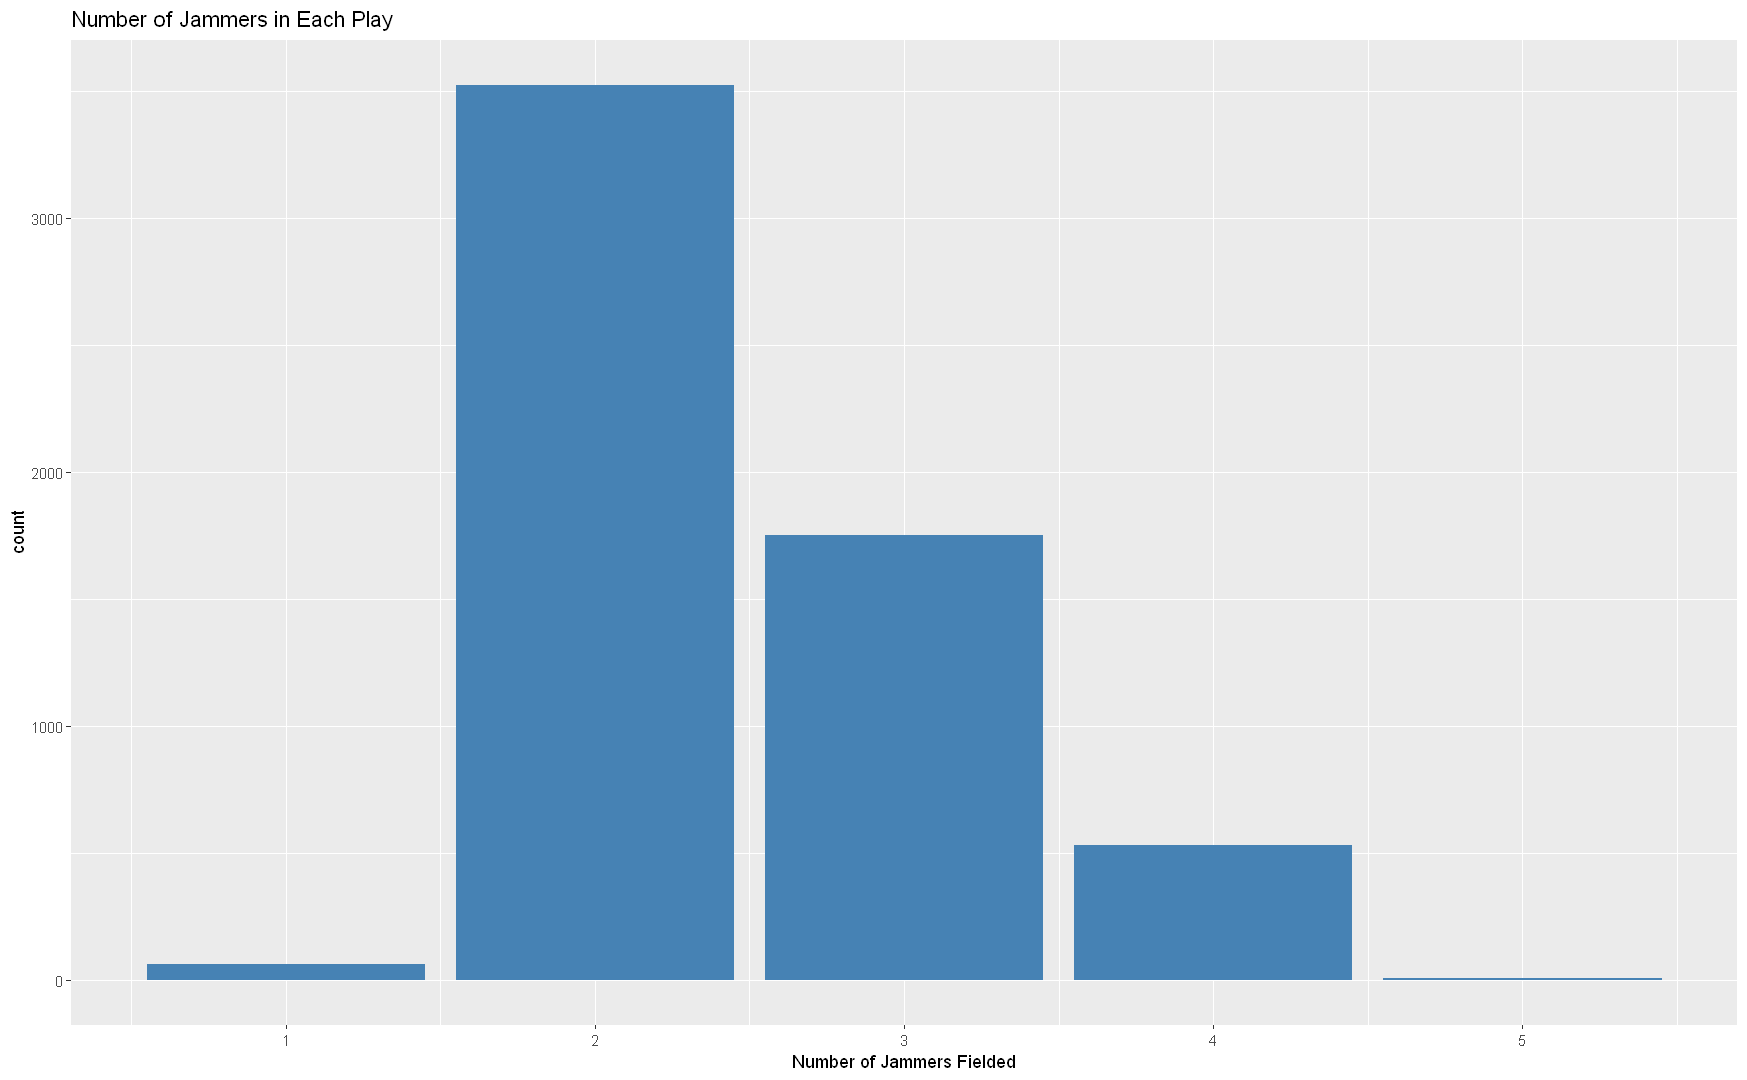

In [14]:
ggplot(data=PFFData, aes(x=str_count(vises, ';') + 1)) +
  geom_bar(stat="count", fill = "steelblue") +
  ggtitle("Number of Jammers in Each Play") +
  xlab("Number of Jammers Fielded")

Warning message:
"Removed 13041 rows containing non-finite values (stat_count)."


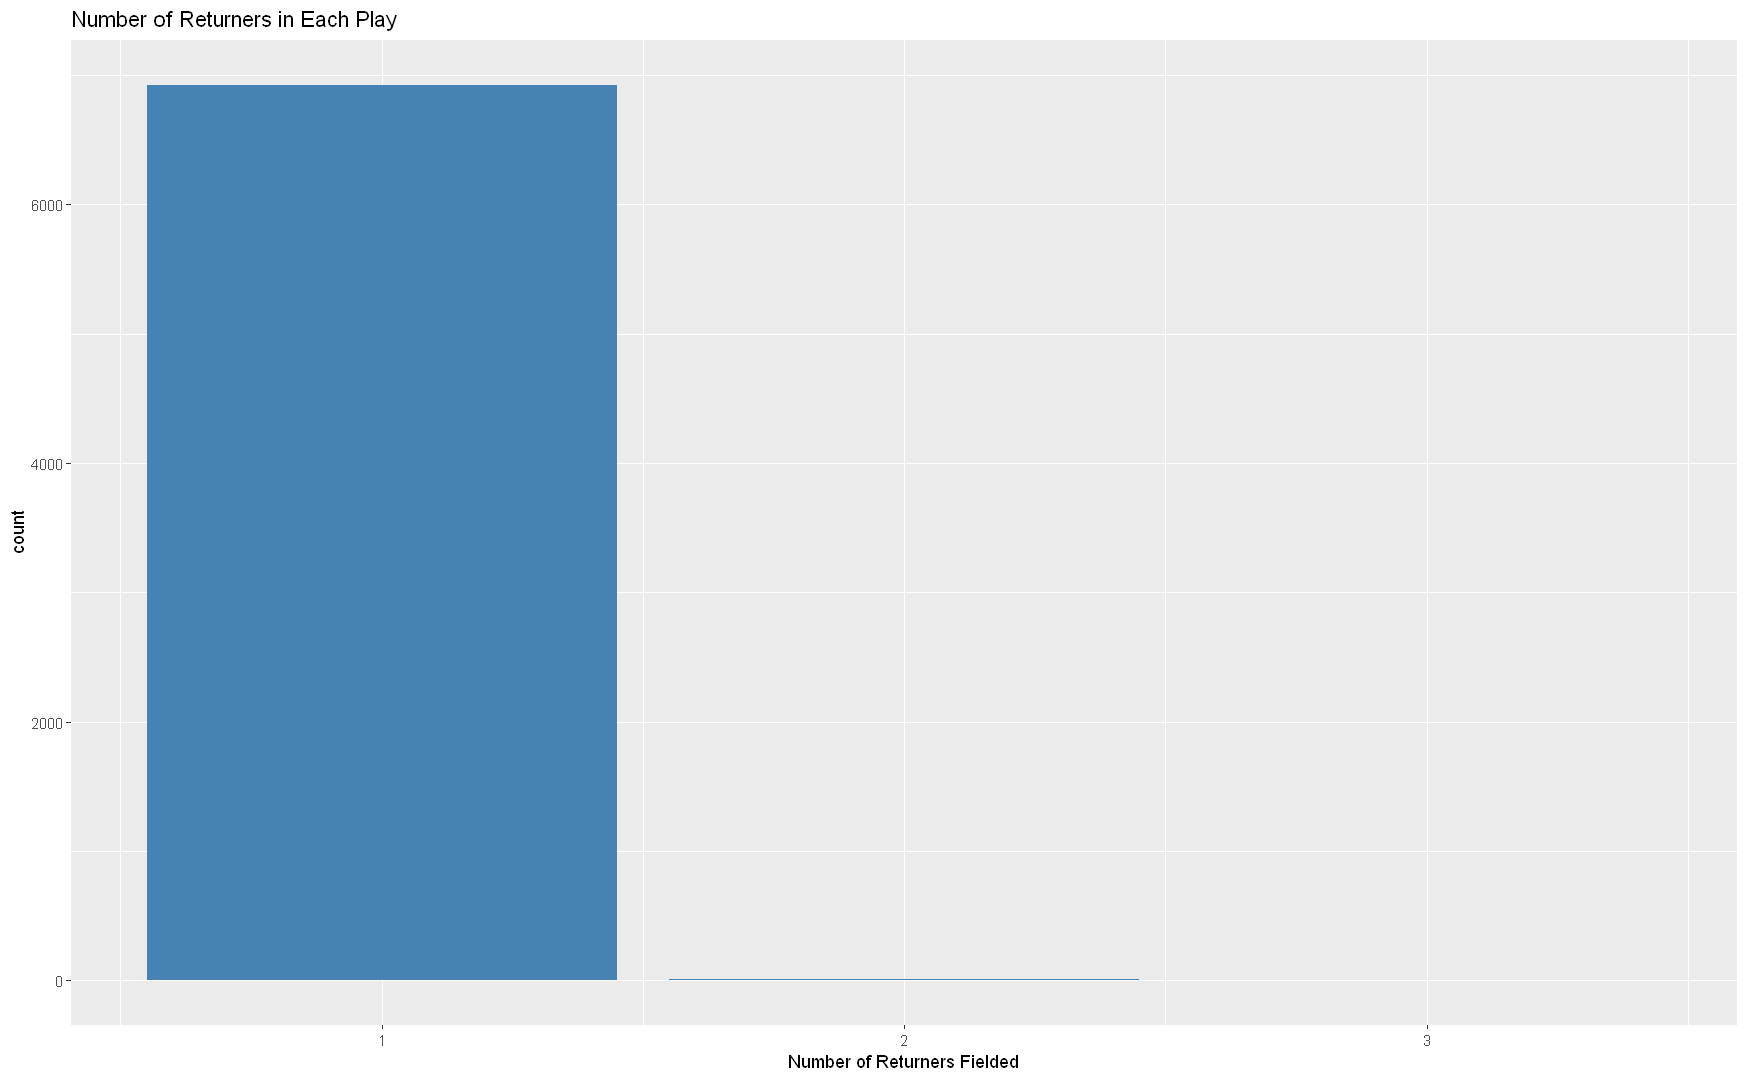

In [15]:
ggplot(data=playData, aes(x=str_count(returnerId, ';') + 1)) +
  geom_bar(stat="count", fill = "steelblue") +
  ggtitle("Number of Returners in Each Play") +
  xlab("Number of Returners Fielded")

### 1.2.2 Condense Play Selection
Any non-punt plays can be removed by filtering the *specialTeamsPlayType* variable to 'Punt'. Plays with an unwanted number of gunners, jammers, or returners can be removed by counting the number of semi-colons. I will also be removing plays that were muffed.

In [16]:
puntPlays <- (mergedData %>% filter(specialTeamsPlayType == 'Punt' &
                                    specialTeamsResult != 'Muffed' &
                                    str_count(gunners, ';') == 1 & 
                                    str_count(vises, ';') == 1 & 
                                    str_count(returnerId, ';') == 0))

### 1.2.3 Remove Rows With NAs in Certain Columns
Later in the analysis, I will need to know at which point the ball is caught. This is possible using the *event* variable. This variable designates if an important event happened at the frame e.g., "fair_catch", "punt_received", "punt_land". However, there are some plays where none of these events are listed. To estimate when the ball is caught, I can add the *operationTime* and *hangTime* variables to the frame that the ball was snapped. Because these variables are needed, I will remove any rows that contain an NA value in these columns.

In [17]:
sapply(puntPlays[c("operationTime", "hangTime")], 
       function(x) sum(is.na(x)))

puntPlays <- puntPlays[complete.cases(puntPlays[c('operationTime', 'hangTime')]), ]

operationTime      hangTime 
         1978          3795

### 1.2.4 Flip Plays
Some plays are going left-to-right while others are going right-to-left. To make each play consistent, I can subtract the yardline number and players' x-coordinate from 120.

In [18]:
puntPlays$x <- ifelse(puntPlays$playDirection == 'left',
                      120 - puntPlays$x, 
                      puntPlays$x)

puntPlays$absoluteYardlineNumber <- ifelse(puntPlays$playDirection == 'left', 
                                           120 - puntPlays$absoluteYardlineNumber,
                                           puntPlays$absoluteYardlineNumber)

### 1.2.5 Add *teamAbbr* Variable
The data does not include a variable that explicitly states what team each player plays for. Only a variable that says if the player is home or away and variables that list the home and away teams.

In [19]:
puntPlays$teamAbbr <- ifelse(puntPlays$team == 'home',
                             puntPlays$homeTeamAbbr,
                             puntPlays$visitorTeamAbbr)

puntPlays[c(500, 121516, 70510), c("displayName", "team", "homeTeamAbbr", "visitorTeamAbbr", "teamAbbr")]

,displayName,team,homeTeamAbbr,visitorTeamAbbr,teamAbbr
,<chr>,<chr>,<chr>,<chr>,<chr>
500,Brent Urban,home,BAL,CLE,BAL
121516,Nick Dzubnar,away,DEN,LAC,LAC
70510,Matthew Slater,home,NE,NYJ,NE


### 1.2.6 Set The Return Yards to Zero on Plays That Resulted in a Fair Catch
Currently, the data lists the return yardage as NA for plays that resulted in a fair catch. For my purposes, it makes sense to count them as zero yard returns to reflect how many yards a gunner gave up.

In [20]:
puntPlays$returnYds[which(puntPlays$specialTeamsResult == 'Fair Catch')] <- 0

**Note: This process was then repeated for the 2019 and 2020 data sets.**